# Performance plots for stars with asteroseismic information

## Author(s): Sven Buder (SB, WG4)

### History:
190221 SB Created

In [3]:
# Preamble for notebook 

# Compatibility with Python 3
from __future__ import (absolute_import, division, print_function)

try:
    %matplotlib inline
    %config InlineBackend.figure_format='retina'
except:
    pass

# Basic packages
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import os
import sys
import glob
import pickle
import pandas

# Packages to work with FITS and (IDL) SME.out files
import astropy.io.fits as pyfits
from astropy.table import Table, join
from scipy.io.idl import readsav

# Matplotlib and associated packages for plotting
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.transforms import Bbox,TransformedBbox
from matplotlib.image import BboxImage
from matplotlib.legend_handler import HandlerBase
from matplotlib._png import read_png
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.colors import ListedColormap
import matplotlib.colors as colors

params = {
    'font.family'        : 'sans',
    'font.size'          : 17,
    'axes.labelsize'     : 20,
    'ytick.labelsize'    : 16,
    'xtick.labelsize'    : 16,
    'legend.fontsize'    : 20,
    'text.usetex'        : True, 
    'text.latex.preamble': [r'\usepackage{upgreek}', r'\usepackage{amsmath}'],
    }   
plt.rcParams.update(params)

_parula_data = [[0.2081, 0.1663, 0.5292], 
                [0.2116238095, 0.1897809524, 0.5776761905], 
                [0.212252381, 0.2137714286, 0.6269714286], 
                [0.2081, 0.2386, 0.6770857143], 
                [0.1959047619, 0.2644571429, 0.7279], 
                [0.1707285714, 0.2919380952, 0.779247619], 
                [0.1252714286, 0.3242428571, 0.8302714286], 
                [0.0591333333, 0.3598333333, 0.8683333333], 
                [0.0116952381, 0.3875095238, 0.8819571429], 
                [0.0059571429, 0.4086142857, 0.8828428571], 
                [0.0165142857, 0.4266, 0.8786333333], 
                [0.032852381, 0.4430428571, 0.8719571429], 
                [0.0498142857, 0.4585714286, 0.8640571429], 
                [0.0629333333, 0.4736904762, 0.8554380952], 
                [0.0722666667, 0.4886666667, 0.8467], 
                [0.0779428571, 0.5039857143, 0.8383714286], 
                [0.079347619, 0.5200238095, 0.8311809524], 
                [0.0749428571, 0.5375428571, 0.8262714286], 
                [0.0640571429, 0.5569857143, 0.8239571429], 
                [0.0487714286, 0.5772238095, 0.8228285714], 
                [0.0343428571, 0.5965809524, 0.819852381], 
                [0.0265, 0.6137, 0.8135], 
                [0.0238904762, 0.6286619048, 0.8037619048], 
                [0.0230904762, 0.6417857143, 0.7912666667], 
                [0.0227714286, 0.6534857143, 0.7767571429], 
                [0.0266619048, 0.6641952381, 0.7607190476], 
                [0.0383714286, 0.6742714286, 0.743552381], 
                [0.0589714286, 0.6837571429, 0.7253857143], 
                [0.0843, 0.6928333333, 0.7061666667], 
                [0.1132952381, 0.7015, 0.6858571429], 
                [0.1452714286, 0.7097571429, 0.6646285714], 
                [0.1801333333, 0.7176571429, 0.6424333333], 
                [0.2178285714, 0.7250428571, 0.6192619048], 
                [0.2586428571, 0.7317142857, 0.5954285714], 
                [0.3021714286, 0.7376047619, 0.5711857143], 
                [0.3481666667, 0.7424333333, 0.5472666667], 
                [0.3952571429, 0.7459, 0.5244428571], 
                [0.4420095238, 0.7480809524, 0.5033142857], 
                [0.4871238095, 0.7490619048, 0.4839761905], 
                [0.5300285714, 0.7491142857, 0.4661142857], 
                [0.5708571429, 0.7485190476, 0.4493904762],
                [0.609852381, 0.7473142857, 0.4336857143], 
                [0.6473, 0.7456, 0.4188], 
                [0.6834190476, 0.7434761905, 0.4044333333], 
                [0.7184095238, 0.7411333333, 0.3904761905], 
                [0.7524857143, 0.7384, 0.3768142857], 
                [0.7858428571, 0.7355666667, 0.3632714286], 
                [0.8185047619, 0.7327333333, 0.3497904762], 
                [0.8506571429, 0.7299, 0.3360285714], 
                [0.8824333333, 0.7274333333, 0.3217], 
                [0.9139333333, 0.7257857143, 0.3062761905], 
                [0.9449571429, 0.7261142857, 0.2886428571], 
                [0.9738952381, 0.7313952381, 0.266647619], 
                [0.9937714286, 0.7454571429, 0.240347619], 
                [0.9990428571, 0.7653142857, 0.2164142857], 
                [0.9955333333, 0.7860571429, 0.196652381], 
                [0.988, 0.8066, 0.1793666667], 
                [0.9788571429, 0.8271428571, 0.1633142857], 
                [0.9697, 0.8481380952, 0.147452381], 
                [0.9625857143, 0.8705142857, 0.1309], 
                [0.9588714286, 0.8949, 0.1132428571], 
                [0.9598238095, 0.9218333333, 0.0948380952], 
                [0.9661, 0.9514428571, 0.0755333333], 
                [0.9763, 0.9831, 0.0538]]

parula = ListedColormap(_parula_data, name='parula')
parula_zero = _parula_data[0]
parula_0 = ListedColormap(_parula_data, name='parula_0')
parula_0.set_bad((1,1,1))
parula_r = ListedColormap(_parula_data[::-1], name='parula_r')

willi_blau = [0.0722666667, 0.4886666667, 0.8467]

In [4]:
#seis = Table.read('../../../input/asteroseismic_information/k2_stello_tmass_matched_overlap_GALAH.fits',1)
seis = Table.read('../../../input/asteroseismic_information/syd_sub.fits',1)
sme = Table.read('../../../catalogs/GALAH_DR3_main_200604_extended_caution_v2.fits',1)

In [5]:
data = join(seis,sme,keys='sobject_id')

# match_seis_data = []
# match_data_seis = []

# for each_seis_index, each_seis_id in enumerate(seis['sobject_id']):
#     match = np.where(sme['sobject_id'] == each_seis_id)[0]
#     if len(match) > 0:
#         for each_match_index in match:
#             match_seis_data.append(each_seis_index)
#             match_data_seis.append(each_match_index)

# match_seis_data = np.array(match_seis_data)
# match_data_seis = np.array(match_data_seis)

# seis = seis[match_seis_data]
# sme = sme[match_data_seis]

# data = table.join(seis, sme)

In [6]:
logg_parallax = data['logg']
logg_numax = np.log10(data['numax']/3090.0*np.sqrt(data['teff']/5772.0)*10.0**4.438)

In [55]:
dwarf_contamination = (logg_parallax > 3.5) | (data['teff'] > 6000)
numax_overd3dex = (np.abs(logg_numax - 3.0) < 0.15) & (logg_parallax - logg_numax > 0.3) & (~dwarf_contamination)

better = (~dwarf_contamination) & (~numax_overd3dex) & np.isfinite(data['teff']) & np.isfinite(logg_numax) & (data['flag_sp'] <= 0)
better = np.isfinite(data['teff']) & np.isfinite(logg_numax) & (data['flag_sp'] <= 0)


In [67]:
np.mean(logg_parallax[better] - logg_numax[better]),np.std(logg_parallax[better] - logg_numax[better])

logg_start = 1.525
logg_end = 3.325
logg_step = 0.05

numax_accuracy = []

for each_logg_bin in np.arange(logg_start, logg_end + logg_step, logg_step):
    in_bin = better & (logg_numax >= each_logg_bin) & (logg_numax < each_logg_bin+logg_step)
    
    p = np.percentile(logg_parallax[in_bin] - logg_numax[in_bin],q=[16,50,84])    
    
    numax_accuracy.append([each_logg_bin+0.5*logg_step, p[1], p[1]-p[0], p[2]-p[1]])
    
numax_accuracy = np.array(numax_accuracy)

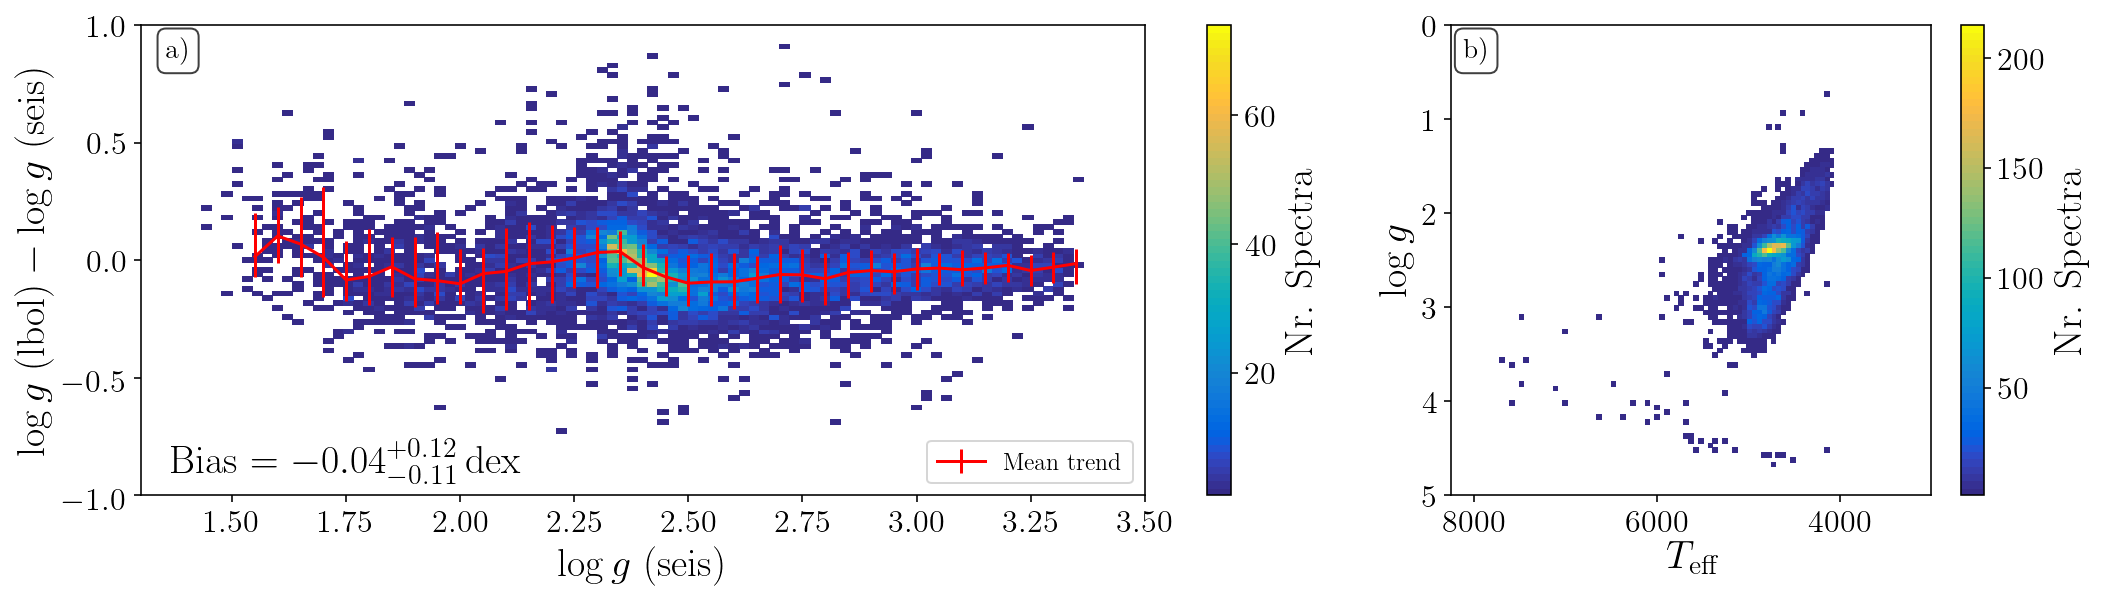

In [68]:
f = plt.figure(figsize=(15,8))

kwargs_scatter = dict(s=1, zorder=1, rasterized = True)

ax1 = plt.subplot2grid((2, 3), (0, 0), colspan=2)
ax2 = plt.subplot2grid((2, 3), (0, 2))

dwarf_contamination_arrow = (logg_parallax > 3.5) | (data['teff'] > 6000) & (logg_parallax - logg_numax > 1.0)

# for each_label, each_group in zip(['Misclassification'],[(numax_overd3dex | dwarf_contamination)]):
#     s1 = ax1.scatter(
#         logg_numax[each_group],
#         logg_parallax[each_group] - logg_numax[each_group],
#         label=each_label,
#         c='C1',
#         **kwargs_scatter
#     )

#     s2 = ax2.scatter(
#         data['teff'][each_group],
#         data['logg'][each_group],
#         c='C1',
#         **kwargs_scatter
#     )
    
p, y, x, s = ax1.hist2d(
    logg_numax[better],
    logg_parallax[better] - logg_numax[better],
    bins=(
        np.linspace(1.3,3.5,100),
        np.linspace(-1,1,100)
    ),
    cmin=1,
    cmap=parula,
    label='good',
    zorder=2,
    rasterized = True
)
c = plt.colorbar(s, ax=ax1)
c.set_label('Nr. Spectra')

p, y, x, s = ax2.hist2d(
    data['teff'][better],
    data['logg'][better],
    bins=(
        np.linspace(3000,8250,100),
        np.linspace(0,5,100)
    ),
    cmin=1,
    cmap=parula,
    label='good',
    zorder=2,
    rasterized = True
)
c = plt.colorbar(s, ax=ax2)
c.set_label('Nr. Spectra')

ax1.errorbar(
    numax_accuracy[:,0],
    numax_accuracy[:,1],
    yerr=[numax_accuracy[:,2],numax_accuracy[:,3]],
    c='r',
    zorder=3,
    label='Mean trend',
    rasterized = True
)

# for each_logg in logg_numax[dwarf_contamination_arrow]:
#     ax1.arrow(
#         each_logg,
#         0.9,
#         0.0,
#         0.05,
#         color='C1',
#         head_width=0.025,
#         alpha=0.5
#     )

p = np.percentile(logg_parallax[better] - logg_numax[better],q=[16,50,84])

ax1.text(0.03,0.03,r'Bias = $'+r"{b:5.2f}".format(b=p[1])+'_{-'+"{s1:5.2f}".format(s1=p[1]-p[0])+'}^{+'+"{s2:5.2f}".format(s2=p[2]-p[1])+'}\,\mathrm{dex}$',transform=ax1.transAxes,fontsize=20)

ax1.legend(loc = 'lower right', ncol=2, fontsize=12)
ax1.set_xlabel(r'$\log g~(\text{seis})$')
ax1.set_ylabel(r'$\log g~(\text{lbol}) - \log g~(\text{seis})$')

ax2.set_xlim(8250,3000)
ax2.set_ylim(5,0)
ax2.set_xlabel(r'$T_\text{eff}$')
ax2.set_ylabel(r'$\log g$')

props = dict(boxstyle='round', facecolor='w', alpha=0.75)
ax1.text(0.025, 0.975, 'a)', transform=ax1.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
ax2.text(0.025, 0.975, 'b)', transform=ax2.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

plt.tight_layout()
plt.savefig('../../../dr3_release_paper/figures/logg_seis_validation_largesample.png', bbox_inches='tight', dpi=300)

# Old plot including 3.0 overdensity and other outlier classifications

In [5]:
dwarf_contamination = (logg_parallax > 3.5) | (data['teff'] > 6000)

dwarf_contamination_arrow = (logg_parallax > 3.5) | (data['teff'] > 6000) & (logg_parallax - logg_numax > 1.0)

numax_overd3dex = (np.abs(logg_numax - 3.0) < 0.1) & (logg_parallax - logg_numax > 0.3) & (~dwarf_contamination)

outlier_lower = (~dwarf_contamination) & (~numax_overd3dex) & (np.abs(logg_parallax - logg_numax) > 0.3)

good = ~dwarf_contamination & ~outlier_lower & ~numax_overd3dex & np.isfinite(data['teff']) & np.isfinite(logg_numax)

In [6]:
better = good & (np.abs(logg_parallax - logg_numax) < 0.3)
np.mean(logg_parallax[better] - logg_numax[better]),np.std(logg_parallax[better] - logg_numax[better])

logg_start = 1.4
logg_end = 3.35
logg_step = 0.05

numax_accuracy = []

for each_logg_bin in np.arange(logg_start, logg_end + logg_step, logg_step):
    in_bin = better & (logg_numax >= each_logg_bin) & (logg_numax < each_logg_bin+logg_step)
    
    numax_accuracy.append([each_logg_bin+0.5*logg_step, np.mean(logg_parallax[in_bin] - logg_numax[in_bin]),np.std(logg_parallax[in_bin] - logg_numax[in_bin])])
    
numax_accuracy = np.array(numax_accuracy)

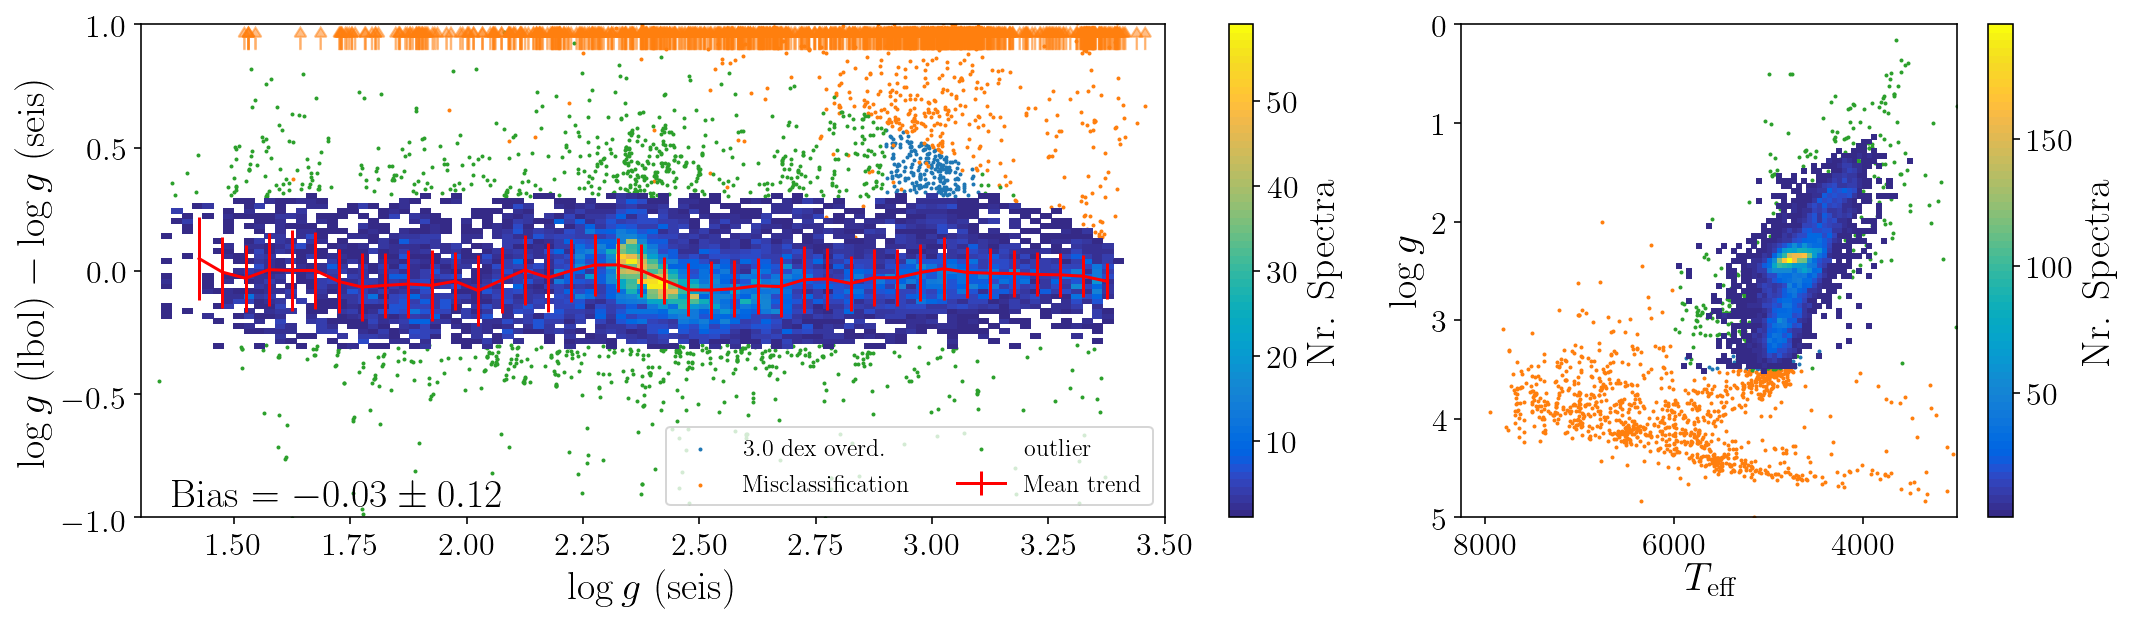

In [7]:
f = plt.figure(figsize=(15,8))

kwargs_scatter = dict(s=1, zorder=1, rasterized = True)

ax1 = plt.subplot2grid((2, 3), (0, 0), colspan=2)
ax2 = plt.subplot2grid((2, 3), (0, 2))

for each_label, each_group in zip(['3.0 dex overd.','Misclassification','outlier'],[numax_overd3dex, dwarf_contamination,outlier_lower]):
    s1 = ax1.scatter(
        logg_numax[each_group],
        logg_parallax[each_group] - logg_numax[each_group],
        label=each_label,
        **kwargs_scatter
    )

    s2 = ax2.scatter(
        data['teff'][each_group],
        data['logg'][each_group],
        **kwargs_scatter
    )
    
p, y, x, s = ax1.hist2d(
    logg_numax[better],
    logg_parallax[better] - logg_numax[better],
    bins=(
        np.linspace(1.3,3.5,100),
        np.linspace(-1,1,100)
    ),
    cmin=1,
    cmap=parula,
    label='good',
    zorder=2,
    rasterized = True
)
c = plt.colorbar(s, ax=ax1)
c.set_label('Nr. Spectra')

p, y, x, s = ax2.hist2d(
    data['teff'][better],
    data['logg'][better],
    bins=(
        np.linspace(3000,8250,100),
        np.linspace(0,5,100)
    ),
    cmin=1,
    cmap=parula,
    label='good',
    zorder=2,
    rasterized = True
)
c = plt.colorbar(s, ax=ax2)
c.set_label('Nr. Spectra')

ax1.errorbar(
    numax_accuracy[:,0],
    numax_accuracy[:,1],
    yerr=numax_accuracy[:,2],
    c='r',
    zorder=3,
    label='Mean trend',
    rasterized = True
)

for each_logg in logg_numax[dwarf_contamination_arrow]:
    ax1.arrow(
        each_logg,
        0.9,
        0.0,
        0.05,
        color='C1',
        head_width=0.025,
        alpha=0.5
    )

ax1.text(0.03,0.03,r'Bias = $'+"{b:5.2f} \pm {s:5.2f}".format(b=np.mean(logg_parallax[better] - logg_numax[better]),s=np.std(logg_parallax[better] - logg_numax[better]))+'$',transform=ax1.transAxes,fontsize=20)

ax1.legend(loc = 'lower right', ncol=2, fontsize=12)
ax1.set_xlabel(r'$\log g~(\text{seis})$')
ax1.set_ylabel(r'$\log g~(\text{lbol}) - \log g~(\text{seis})$')

ax2.set_xlim(8250,3000)
ax2.set_ylim(5,0)
ax2.set_xlabel(r'$T_\text{eff}$')
ax2.set_ylabel(r'$\log g$')

plt.tight_layout()
plt.savefig('figures/logg_seis_validation_largesample.pdf', bbox_inches='tight', dpi=300)

In [ ]:
len(logg_numax[dwarf_contamination_arrow])/len(logg_numax)*100.,len(logg_numax[better]),len(logg_numax)